# Image Classification Using fastai

A quick example of using `fastai` tools to perfom basic image classification.

In [1]:
## PyTorch doesn't fully support MPS devices yet (as of Feb 5, 2024)
## See: https://github.com/pytorch/pytorch/issues/77764#
## The following allows PyTorch to fall back to the CPU whenever it
## encounters an unsupported operation
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
## Import the tools needed
import requests, time
from urllib.error import URLError, HTTPError
import fastai
from fastai.vision.all import *

In [3]:
## From https://github.com/fastai/course20/blob/b84f6cf90ce20265ee8d0a539c234f4abf05301a/fastbook/__init__.py#L53
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

I want to try and classify buildings as churches, schools, or prisons. So, I'll download some traing data for images searches with the following terms:

- church building
- school building
- prison building
  
I'll do this using the search function `search_images_ddg` provided by fastai, that searches for images using DuckDuckGo

In [4]:
building_type = ['church', 'school', 'prison']
path = Path('buildings_data')

In [5]:
## Use DuckDuckGo! to get some training data
## Uncomment this to redo search and download...
if not path.exists():
    path.mkdir()
    for building in building_type:
        dest = (path/building)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{building} building', 300)
        download_images(dest, urls=results)

## Get the filenames
fns = get_image_files(path)

## Check for failed images
failed = verify_images(fns)

## Unlink the failed images
failed.map(Path.unlink)

(#33) [None,None,None,None,None,None,None,None,None,None...]

In [6]:
## Break up the data into training and validation sets
buildings = DataBlock(
    ## Define the types for the indpendent and dependent variable
    blocks=(ImageBlock, CategoryBlock),
    ## Get a list of the images in the path
    get_items=get_image_files,
    ## Split into training and validation sets
    splitter=RandomSplitter(valid_pct=.2, seed=90210),
    ## Get the target values (labels)
    get_y = parent_label,
    ## Perform randomized resizinng and cropping
    item_tfms=RandomResizedCrop(256, min_scale=0.3),
    ## Augment the data with default transforms
    batch_tfms = aug_transforms()
)

## Process the data
dls = buildings.dataloaders(path)

/Users/marcos/miniconda3/envs/fastai/lib/python3.11/site-packages/torch/_tensor.py:1386: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


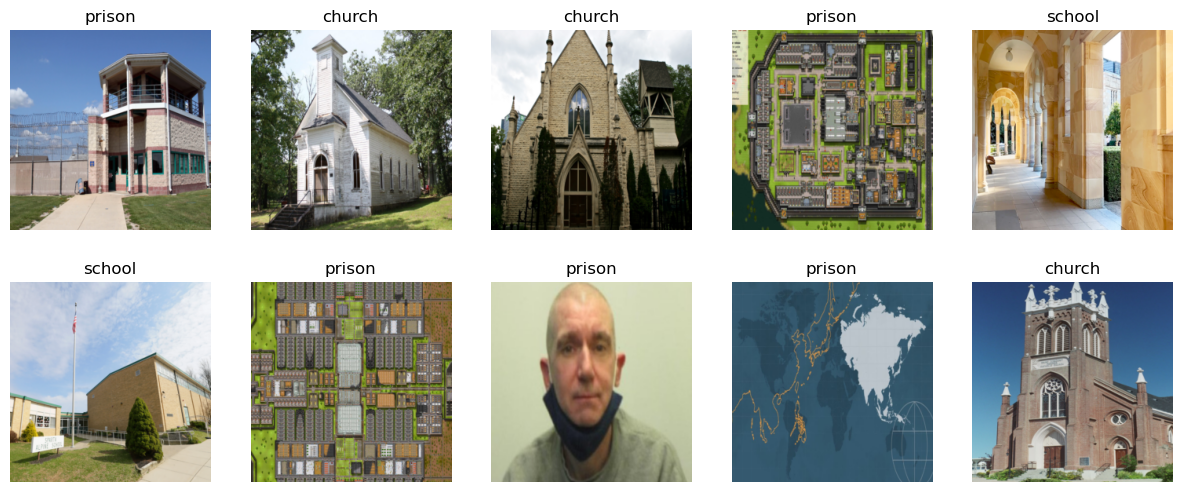

In [7]:
## Check out some of the raw data
dls.valid.show_batch(max_n=10, nrows=2)

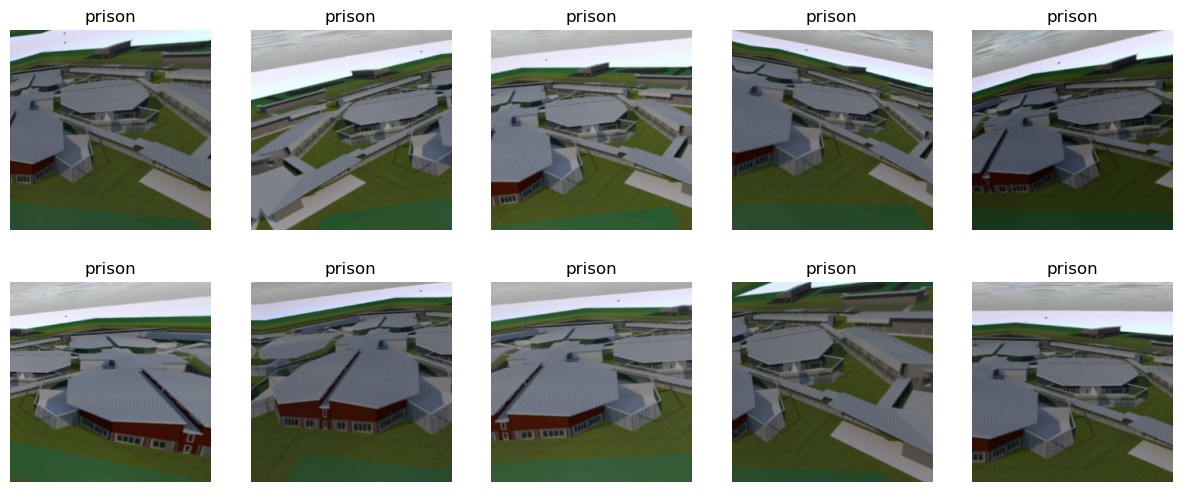

In [8]:
## Look at a single example of the training data
dls.train.show_batch(max_n=10, nrows=2, unique=True)

In [9]:
##. Train the model
learn = vision_learner(dls, resnet18, metrics=error_rate)

##. Itterate over a few epochs to learn better parameters
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.836733,0.953064,0.316129,00:25


/Users/marcos/miniconda3/envs/fastai/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.991980,0.752438,0.251613,00:21
1,0.908823,0.726772,0.238710,00:20
2,0.832277,0.651820,0.206452,00:19
3,0.747627,0.630435,0.200000,00:19
4,0.663450,0.644580,0.200000,00:19
5,0.606534,0.637947,0.200000,00:19


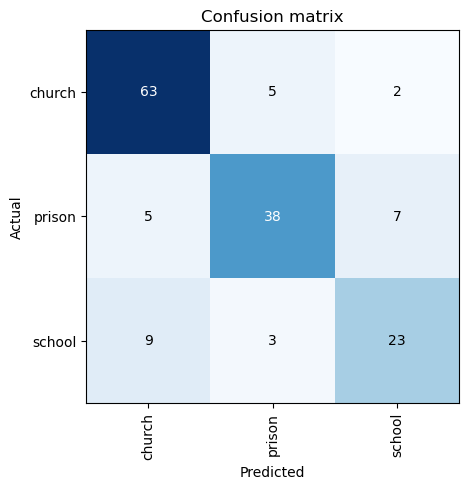

In [10]:
## Peek at model perfomace indicators
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

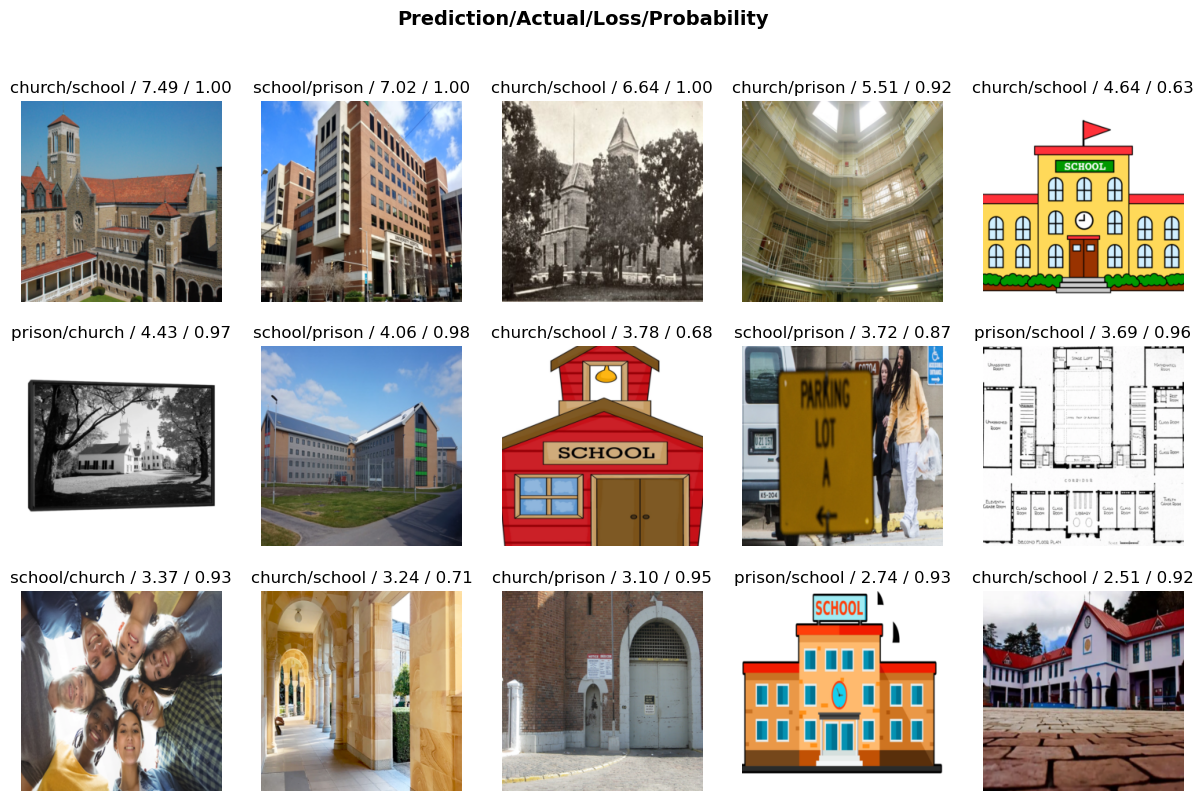

In [11]:
##. Peek at where the model wasn't doing so hot
interp.plot_top_losses(15, nrows=3)